In [1]:
"""
diffusion_equation_2.ipynb

Created on Thu Apr 6 2023

@author: Lukas

This notebook contains all experiments on the more complicated Diffusion Equation from this 
(https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/diffusion.reaction.html) DeepXDE demo.
"""

'\ndiffusion-reaction_equation_2.ipynb\n\nCreated on Thu Apr 6 2023\n\n@author: Luca d'Amico-Wong, Lukas Fesser, Richard Qiu\n\nThis notebook contains all experiments on the more complicated Diffusion Equation from this \n(https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/diffusion.reaction.html) DeepXDE demo.\n'

In this notebook, we solve the diffusion equation
$$\frac{\delta y}{\delta t} = \frac{\delta^2 y}{\delta x^2} - e^{-t} \left( 3 \frac{\sin (2 x)}{2} + 8 \frac{\sin (3 x)}{3} + 15 \frac{\sin (4x)}{4} + 63 \frac{\sin (8x)}{8}  \right) $$

for $x \in [-\pi, \pi]$ and $t \in [0, 1]$ with the initial condition 
$$y(x, 0) = \sin (x) + \frac{\sin (2 x)}{2} + \frac{\sin (3 x)}{3} + \frac{\sin (4x)}{4} + \frac{\sin (8x)}{8}$$

and the Dirichlet boundary condition $y(-\pi, t) = y(\pi, t) = 0$. The reference solution is 
$$y = e^{-t} \left( \sin (x) + \frac{\sin (2 x)}{2} + \frac{\sin (3 x)}{3} + \frac{\sin (4x)}{4} + \frac{\sin (8x)}{8} \right)$$

We use $t \in [0, 0.5]$ as the temporal training domain and consider $t \in (0.5, 1]$ as the extrapolation area.

In [2]:
# install DeepXDE

%pip install deepxde

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.7/150.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 8.0 MB/s eta 0:00:00


In [3]:
# import packages

import deepxde as dde
import numpy as np

from deepxde.backend import tf

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
import random

DeepXDE backend not selected or invalid. Use tensorflow.compat.v1.
Using backend: tensorflow.compat.v1



Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Instructions for updating:
non-resource variables are not supported in the long term


Enable just-in-time compilation with XLA.



In [73]:
# set up the problem

def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    d = 1
    return (
        dy_t
        - d * dy_xx
        - tf.exp(-x[:, 1:])
        * (
            3 * tf.sin(2 * x[:, 0:1]) / 2
            + 8 * tf.sin(3 * x[:, 0:1]) / 3
            + 15 * tf.sin(4 * x[:, 0:1]) / 4
            + 63 * tf.sin(8 * x[:, 0:1]) / 8
        )
    )

def func(x):
    return np.exp(-x[:, 1:]) * (
        np.sin(x[:, 0:1])
        + np.sin(2 * x[:, 0:1]) / 2
        + np.sin(3 * x[:, 0:1]) / 3
        + np.sin(4 * x[:, 0:1]) / 4
        + np.sin(8 * x[:, 0:1]) / 8
    )


geom = dde.geometry.Interval(-np.pi, np.pi)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# define the boundary and initial conditions
bc = dde.icbc.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, func, lambda _, on_initial: on_initial)

data = dde.data.TimePDE(
    geomtime, pde, [bc, ic], num_domain=320, num_boundary=20,
    num_initial=10, solution=func, num_test=10000)

In [86]:
# set up the model

layer_size = [2] + [10] * 2 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

# Backend tensorflow.compat.v1 or tensorflow
def output_transform(x, y):
    return (
        x[:, 1:2] * (np.pi ** 2 - x[:, 0:1] ** 2) * y
        + tf.sin(x[:, 0:1])
        + tf.sin(2 * x[:, 0:1]) / 2
        + tf.sin(3 * x[:, 0:1]) / 3
        + tf.sin(4 * x[:, 0:1]) / 4
        + tf.sin(8 * x[:, 0:1]) / 8
    )

#net.apply_output_transform(output_transform)

model = dde.Model(data, net)
model.compile("adam", lr=1e-3, metrics=["l2 relative error"])

Compiling model...
Building feed-forward neural network...
'build' took 0.112187 s

'compile' took 1.475408 s



In [10]:
losshistory, train_state = model.train(iterations=30000)

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [2.50e+01, 4.76e-01, 1.54e+00]    [2.67e+01, 4.76e-01, 1.54e+00]    [1.55e+00]    
1000      [4.67e-02, 1.47e-03, 4.82e-04]    [4.23e-02, 1.47e-03, 4.82e-04]    [3.43e-02]    
2000      [3.45e-03, 5.69e-04, 1.26e-05]    [3.68e-03, 5.69e-04, 1.26e-05]    [1.21e-02]    
3000      [1.78e-03, 3.23e-04, 3.95e-05]    [1.94e-03, 3.23e-04, 3.95e-05]    [9.21e-03]    
4000      [4.95e-03, 9.88e-04, 1.49e-04]    [3.59e-03, 9.88e-04, 1.49e-04]    [2.59e-02]    
5000      [1.63e-02, 3.06e-04, 1.64e-04]    [1.43e-02, 3.06e-04, 1.64e-04]    [1.25e-02]    
6000      [1.97e-03, 1.61e-04, 6.51e-05]    [2.19e-03, 1.61e-04, 6.51e-05]    [7.70e-03]    
7000      [2.12e-03, 1.57e-04, 5.50e-05]    [2.24e-03, 1.57e-04, 5.50e-05]    [7.50e-03]    
8000      [1.45e-02, 8.03e-04, 2.73e-04]    [1.35e-02, 8.03e-04, 2.73e-04]    [2.07e-02]    
9000      [1.30e-02, 1.44

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


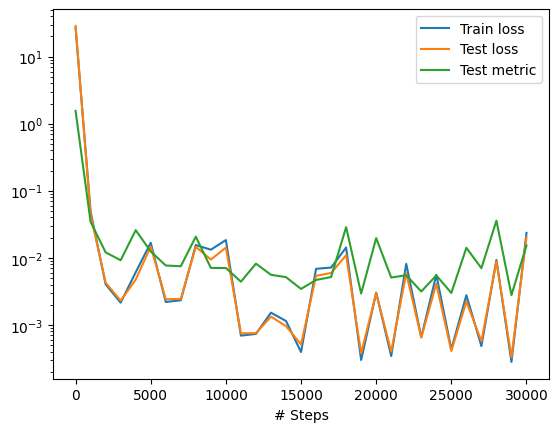

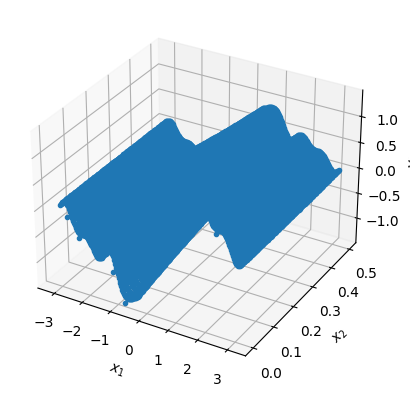

In [11]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [87]:
zero_predictions = []
half_predictions = []
one_predictions = []

In [88]:
# predict the solution at t = 0 for x in [-1, 1]

for i in range(6):
    model.train(iterations=5000)

    x = geom.uniform_points(256, True)
    t = np.full(256, 0.1)
    x = np.hstack((x, t.reshape(-1, 1)))    
    y = model.predict(x)
    zero_predictions.append(y)

    x = geom.uniform_points(256, True)
    t = np.full(256, 0.5)
    x = np.hstack((x, t.reshape(-1, 1)))
    y = model.predict(x)
    half_predictions.append(y)

    x = geom.uniform_points(256, True)
    t = np.full(256, 1.0)
    x = np.hstack((x, t.reshape(-1, 1)))
    y = model.predict(x)
    one_predictions.append(y)

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [1.71e+01, 8.89e-02, 5.70e-01]    [1.80e+01, 8.89e-02, 5.70e-01]    [8.15e-01]    
1000      [6.19e+00, 4.48e-02, 9.89e-02]    [6.70e+00, 4.48e-02, 9.89e-02]    [5.06e-01]    
2000      [4.48e+00, 2.71e-02, 2.77e-02]    [4.77e+00, 2.71e-02, 2.77e-02]    [2.15e-01]    
3000      [2.45e+00, 6.45e-02, 7.83e-02]    [2.56e+00, 6.45e-02, 7.83e-02]    [5.76e-01]    
4000      [1.79e+00, 1.55e-02, 4.96e-02]    [1.94e+00, 1.55e-02, 4.96e-02]    [2.45e-01]    
5000      [5.60e-01, 7.55e-03, 2.22e-02]    [4.89e-01, 7.55e-03, 2.22e-02]    [2.48e-01]    

Best model at step 5000:
  train loss: 5.90e-01
  test loss: 5.18e-01
  test metric: [2.48e-01]

'train' took 11.882195 s

Training model...

Step      Train loss                        Test loss                         Test metric   
5000      [5.60e-01, 7.55e-03, 2.22e-02]    [4.89e-01, 7.55e-03, 2.2

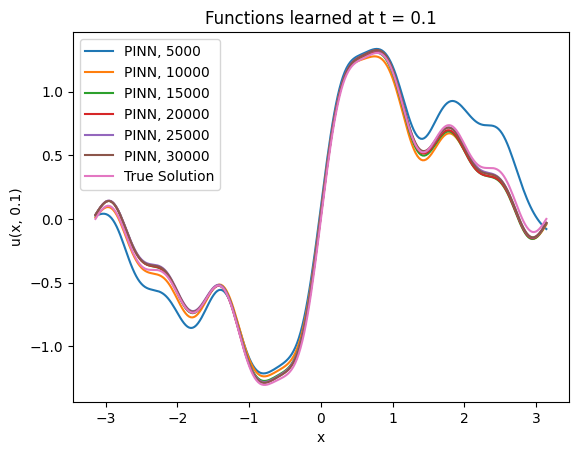

In [89]:
# plot the solution and compare it to the sine function

for i in range(len(zero_predictions)):
    plt.plot(x[:, 0], zero_predictions[i][:, 0], label="PINN, " + str((i+1) * 5000))

plt.plot(x[:, 0], np.exp(-0.1) * (np.sin(x[:, 0]) + np.sin(2*x[:, 0])/2 + np.sin(3*x[:, 0])/3 + np.sin(4*x[:, 0])/4 + np.sin(8*x[:, 0])/8), label="True Solution")
plt.legend()
plt.title("Functions learned at t = 0.1")
plt.xlabel("x")
plt.ylabel("u(x, 0.1)")
plt.show()

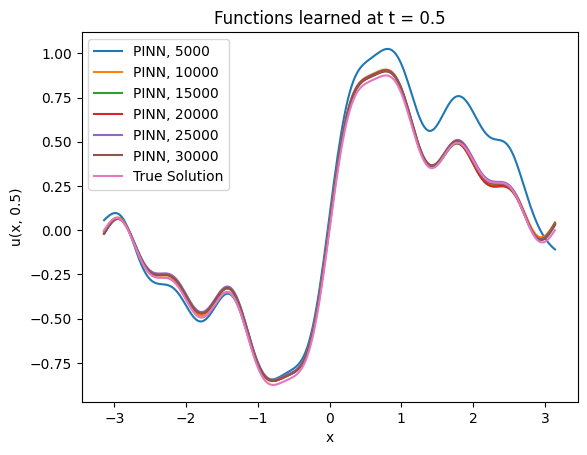

In [90]:
# plot the solution

for i in range(len(half_predictions)):
    plt.plot(x[:, 0], half_predictions[i][:, 0], label="PINN, " + str((i+1) * 5000))

plt.plot(x[:, 0], np.exp(-0.5) * (np.sin(x[:, 0]) + np.sin(2*x[:, 0])/2 + np.sin(3*x[:, 0])/3 + np.sin(4*x[:, 0])/4 + np.sin(8*x[:, 0])/8), label="True Solution")
plt.legend()
plt.title("Functions learned at t = 0.5")
plt.xlabel("x")
plt.ylabel("u(x, 0.5)")
plt.show()

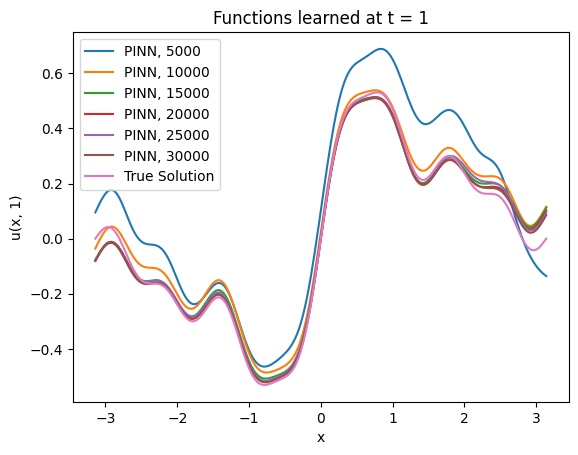

In [91]:
# plot the solution at t = 1

for i in range(len(one_predictions)):
    plt.plot(x[:, 0], one_predictions[i][:, 0] , label="PINN, " + str((i+1) * 5000))

plt.plot(x[:, 0], np.exp(-1) * (np.sin(x[:, 0]) + np.sin(2*x[:, 0])/2 + np.sin(3*x[:, 0])/3 + np.sin(4*x[:, 0])/4 + np.sin(8*x[:, 0])/8), label="True Solution")
plt.legend()
plt.title("Functions learned at t = 1")
plt.xlabel("x")
plt.ylabel("u(x, 1)")
plt.show()

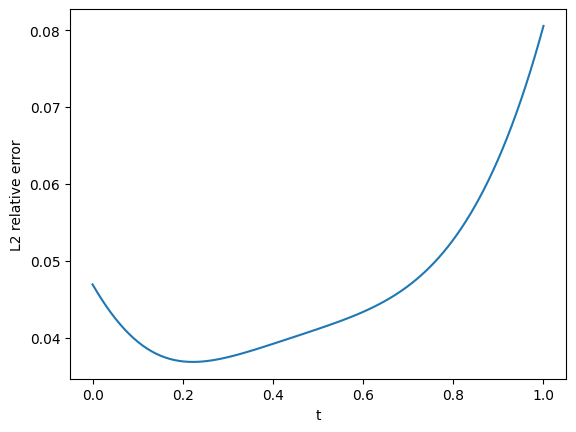

In [92]:
# compute the L2 relative error between the true solution and the predicted solution

rel_l2_errors = []

for t in range(100):
    x = geom.uniform_points(256, True)
    t = np.full(256, t/100)
    x = np.hstack((x, t.reshape(-1, 1)))
    y_pred = model.predict(x)

    y_sol = func(x)

    # collect the relative L2 errors in a list
    rel_l2_errors.append(dde.metrics.l2_relative_error(y_sol, y_pred))


# plot the relative L2 errors

x = np.linspace(0, 1, 100)
plt.plot(x, rel_l2_errors)
plt.xlabel("t")
plt.ylabel("L2 relative error")
plt.show()

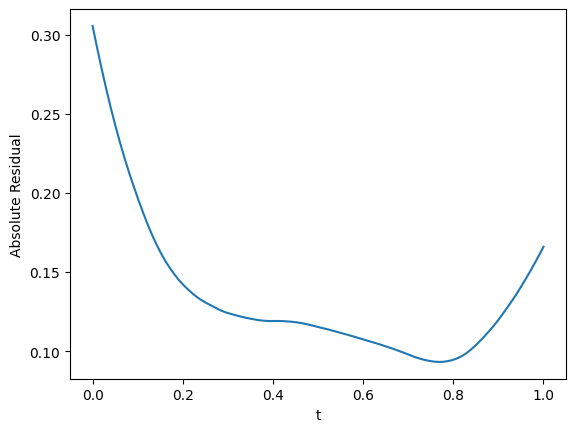

In [93]:
# compute the absolute residuals, i.e. the deviation from the PDE

absolute_residual = []

for t in range(100):
    x = geom.uniform_points(256, True)
    t = np.full(256, t/100)
    X = np.hstack((x, t.reshape(-1, 1)))

    f = model.predict(X, operator=pde)
    absolute_residual.append(np.mean(np.absolute(f)))


# plot the absolute residuals

x = np.linspace(0, 0.01 * 100, 100)
plt.plot(x, absolute_residual)
plt.xlabel("t")
plt.ylabel("Absolute Residual")
plt.show()

In [ ]:
mean_residual_inter = []
mean_residual_extra = []

l2_error_inter = []
l2_error_extra = []

In [ ]:
# set up the model

layer_size = [2] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

net.apply_output_transform(output_transform)

model = dde.Model(data, net)

model.compile("adam", lr=0.0001, metrics=["l2 relative error"])

Compiling model...
Building feed-forward neural network...
'build' took 0.088326 s

'compile' took 1.280385 s



In [ ]:
# record mean residuals and l2-residuals over training epochs for t in [0, 1]

def create_data(t):
    x = geom.uniform_points(256, True)
    t = np.full(256, t/100)
    X = np.hstack((x, t.reshape(-1, 1)))
    return X

for i in range(100):
    model.train(iterations=1000)

    y_pred = np.array([model.predict(create_data(t)) for t in range(100)])
    y_sol = np.array([func(create_data(t)) for t in range(100)])
    # f = np.array([model.predict(create_data(t), operator=pde) for t in range(100)])

    # mean_residual_inter.append(np.mean(np.absolute(f)[:12800]))
    l2_error_inter.append(dde.metrics.l2_relative_error(y_sol[:50, :, :], y_pred[:50, :, :]))

    # mean_residual_extra.append(np.mean(np.absolute(f)[12800:]))
    l2_error_extra.append(dde.metrics.l2_relative_error(y_sol[50:, :, :], y_pred[50:, :, :]))

Training model...

Step      Train loss    Test loss     Test metric   
900000    [1.67e-06]    [2.49e-06]    [3.09e-05]    
901000    [1.67e-06]    [2.49e-06]    [3.09e-05]    

Best model at step 901000:
  train loss: 1.67e-06
  test loss: 2.49e-06
  test metric: [3.09e-05]

'train' took 22.186360 s

Training model...

Step      Train loss    Test loss     Test metric   
901000    [1.67e-06]    [2.49e-06]    [3.09e-05]    
902000    [1.67e-06]    [2.49e-06]    [3.09e-05]    

Best model at step 902000:
  train loss: 1.67e-06
  test loss: 2.49e-06
  test metric: [3.09e-05]

'train' took 21.964763 s

Training model...

Step      Train loss    Test loss     Test metric   
902000    [1.67e-06]    [2.49e-06]    [3.09e-05]    
903000    [1.67e-06]    [2.48e-06]    [3.09e-05]    

Best model at step 903000:
  train loss: 1.67e-06
  test loss: 2.48e-06
  test metric: [3.09e-05]

'train' took 21.514089 s

Training model...

Step      Train loss    Test loss     Test metric   
903000    [1.67e

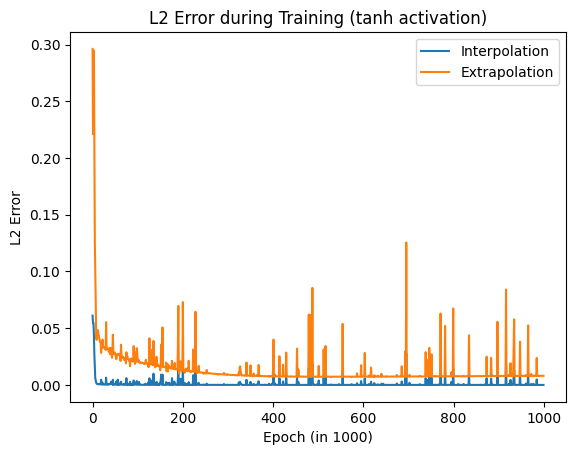

In [ ]:
# plot the mean residual in interpolation and extrapolation against the training epochs

plt.plot([*range(1000)], l2_error_inter, label="Interpolation")
plt.plot([*range(1000)], l2_error_extra, label="Extrapolation")

plt.legend()
plt.title("L2 Error during Training (tanh activation)")
plt.xlabel("Epoch (in 1000)")
plt.ylabel("L2 Error")
plt.show()

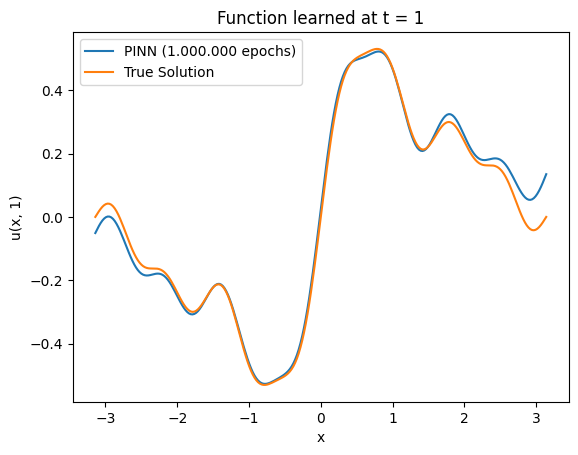

In [12]:
# plot the solution

x = geom.uniform_points(256, True)
t = np.full(256, 1)
x = np.hstack((x, t.reshape(-1, 1)))
y_pred = model.predict(x)

plt.plot(x[:, 0], y_pred, label="PINN (1.000.000 epochs)")

plt.plot(x[:, 0], np.exp(-1) * (np.sin(x[:, 0]) + np.sin(2*x[:, 0])/2 + np.sin(3*x[:, 0])/3 + np.sin(4*x[:, 0])/4 + np.sin(8*x[:, 0])/8), label="True Solution")
plt.legend()
plt.title("Function learned at t = 1")
plt.xlabel("x")
plt.ylabel("u(x, 1)")
plt.show()